In [1]:
import os

for scenario in ["instrat", "instrat_hprices"]:
    for year in [2025, 2030, 2035, 2040]:
        os.environ["PYPSAPL_SCENARIO"] = scenario
        os.environ["PYPSAPL_YEAR"] = str(year)
        %run prepare_input_files.py

Creating buses and connections...
Creating CBF buses and links...
Creating PV & Wind capacity factors...
Creating RES & industrial generators...
Creating JWCD, nJWCD, CHP and HPS generators...
Creating load...
All done :>
Creating buses and connections...
Creating CBF buses and links...
Creating PV & Wind capacity factors...
Creating RES & industrial generators...
Creating JWCD, nJWCD, CHP and HPS generators...
Creating load...
All done :>
Creating buses and connections...
Creating CBF buses and links...
Creating PV & Wind capacity factors...
Creating RES & industrial generators...
Creating JWCD, nJWCD, CHP and HPS generators...
Creating load...
All done :>
Creating buses and connections...
Creating CBF buses and links...
Creating PV & Wind capacity factors...
Creating RES & industrial generators...
Creating JWCD, nJWCD, CHP and HPS generators...
Creating load...
All done :>
Creating buses and connections...
Creating CBF buses and links...
Creating PV & Wind capacity factors...
Creatin

In [2]:
import os

os.environ["PYPSAPL_SCENARIO"] = "instrat_hprices"
os.environ["PYPSAPL_YEAR"] = "2025"
%run run_pypsa_lopf.py

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 100.0s
INFO:pypsa.linopf:Solve linear problem using Cplex solver


Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 2251320 rows and 6973087 columns.
Aggregator did 630720 substitutions.
Reduced LP has 1331520 rows, 4555200 columns, and 11852259 nonzeros.
Presolve time = 48.37 sec. (9081.17 ticks)
Initializing dual steep norms . . .
Elapsed time = 95.80 sec. (20519.78 ticks, 1 iterations)

Iteration log . . .
Iteration:     1   Dual objective     =             0.000000
Perturbation started.
Iteration:   101   Dual objective     =             0.000000
Iteration:  4410   Dual objective     =             0.000001
Iteration:  8337   Dual objective     =             0.000002
Iteration: 12197   Dual objective     =             0.000003
Iteration: 16068   Dual 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.49e+10
INFO:pypsa.io:Exported network network.nc has lines, carriers, buses, links, loads, generators, storage_units


All completed :>


In [ ]:
import os

os.environ["PYPSAPL_SCENARIO"] = "instrat_hprices"
os.environ["PYPSAPL_YEAR"] = "2030"
%run run_pypsa_lopf.py

In [ ]:
import os

os.environ["PYPSAPL_SCENARIO"] = "instrat_hprices"
os.environ["PYPSAPL_YEAR"] = "2035"
%run run_pypsa_lopf.py

In [ ]:
import os

os.environ["PYPSAPL_SCENARIO"] = "instrat_hprices"
os.environ["PYPSAPL_YEAR"] = "2040"
%run run_pypsa_lopf.py

In [3]:
import pandas as pd

def export_capacity_and_production(network):

    df_tech = network.generators.carrier.copy()
    df_tech.name = "Technology"
    for pv_type in ["GROUND", "ROOF"]:
        df_tech[df_tech.index.str.endswith(f"PV_{pv_type}")] = f"PV_{pv_type.capitalize()}"

    df_cap = network.generators.p_nom / 1e3
    df_cap.name = "Installed Capacity [GW]"
    df_cap = pd.merge(df_cap, df_tech, left_index=True, right_index=True, how="left")
    df_cap = df_cap.groupby("Technology").sum().reset_index()

    df_prod = network.generators_t.p.sum().transpose() / 1e6
    df_prod.name = "Electricity Production [TWh]"
    df_prod = pd.merge(df_prod, df_tech, left_index=True, right_index=True, how="left")
    df_prod = df_prod.groupby("Technology").sum().reset_index()

    return df_cap, df_prod

def export_marginal_cost(network):

    mc = network.buses_t.marginal_price.mean().transpose().mean() 
    # It should actually be median - otherwise we include the foreign nodes in our calculation!
    df_mc = pd.DataFrame([mc], columns = ["Mean Marginal Cost [PLN/MWh]"])
    return df_mc


In [5]:
import pypsa

for scenario in ["instrat", "instrat_hprices"]:
    for year in [2025, 2030, 2035, 2040]:
        if scenario != "instrat_hprices" or year != 2025:
            continue
        network = pypsa.Network()
        results_dir = lambda f: f"pypsa/{scenario}/results/{year}/{f}"
        network.import_from_netcdf(results_dir("network.nc"))
        df_cap, df_prod = export_capacity_and_production(network)
        df_mc = export_marginal_cost(network)
        df_cap.round(decimals=2).to_csv(results_dir("capacity.csv"), index=False)
        df_prod.round(decimals=2).to_csv(results_dir("production.csv"), index=False)
        df_mc.round(decimals=2).to_csv(results_dir("marginal_cost.csv"), index=False)


INFO:pypsa.io:Imported network network.nc has buses, carriers, generators, lines, links, loads, storage_units


(<matplotlib.collections.PatchCollection at 0x7fb8b7b2a7d0>,
 <matplotlib.collections.LineCollection at 0x7fb7967fe950>)

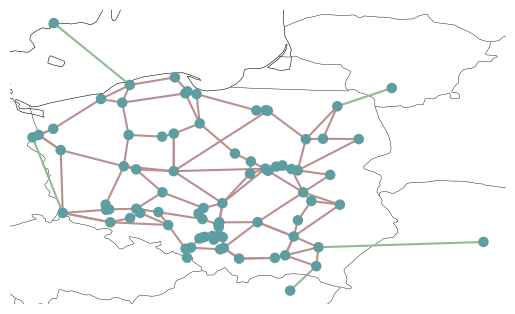

In [6]:
network.plot()

In [9]:
import pandas as pd

dfs_p = []
dfs_mc = []

for scenario in ["instrat", "instrat_hprices"]:
    for year in [2025, 2030, 2035, 2040]:
        if scenario == "instrat_hprices" and year != 2025:
            continue
        results_dir = lambda f: f"pypsa/{scenario}/results/{year}/{f}"

        df_cap = pd.read_csv(results_dir("capacity.csv"))
        df_prod = pd.read_csv(results_dir("production.csv"))
        df_p = pd.merge(df_cap, df_prod, on="Technology", how="outer")
        df_p["Year"] = year
        df_p["Scenario"] = scenario
        dfs_p.append(df_p)

        df_mc = pd.read_csv(results_dir("marginal_cost.csv"))
        df_mc["Year"] = year
        df_mc["Scenario"] = scenario
        dfs_mc.append(df_mc)

df_p = pd.concat(dfs_p)
df_mc = pd.concat(dfs_mc)


years = df_p["Year"].unique()
scenarios = df_p["Scenario"].unique()
techs = df_p["Technology"].unique()
techs = techs[(techs != "CBF") & (techs != "DSR")]
index = ["Scenario", "Year", "Technology"]
df_index = pd.DataFrame(
    index=pd.MultiIndex.from_product([scenarios, years, techs], names=index)
).reset_index()
df_p = pd.merge(df_index, df_p, on=index, how="left").fillna(0)

df_mc = df_mc[["Scenario", "Year", df_mc.columns[0]]]

os.makedirs("outputs", exist_ok=True)
with pd.ExcelWriter('outputs/pypsapl_outputs.xlsx') as writer:  
    df_p.to_excel(writer, sheet_name='Electricity Mix', index=False)
    df_mc.to_excel(writer, sheet_name='Marginal Costs', index=False)

